<a href="https://colab.research.google.com/github/YanhuaZhang516/memory-representation-pomdp/blob/main/PPO2withLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0
!apt install swig cmake libopenmpi-dev zlib1g-dev
import stable_baselines
stable_baselines.__version__

TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 6.0MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,100 kB of archives.
After this operation

'2.10.0'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns test
sns.set_style("darkgrid")

In [3]:
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLstmPolicy

In [4]:
from stable_baselines.common.policies import *

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Reshape,Embedding,LSTM,Lambda, Concatenate
import tensorflow.keras as keras
from keras.models import load_model

Using TensorFlow backend.


In [6]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from keras import backend as K
from tensorflow.python.platform import gfile

In [7]:
from gridworld2 import *
from gridworldRNN import *

In [8]:
# load the lstm model
def slice(x):
  return x[0,:,:]


def set_lstm(time_steps):
  #set_session(session)

  time_steps=time_steps
  input=Input(shape=(time_steps,10),batch_size=1,name="input")
  output1=Embedding(35,60,name='embedding')(input)
  output1 = Reshape((-1,600),name='reshape')(output1)
  output2, final_memory_state, final_carry_state =(LSTM(units=50, return_sequences=True, return_state=True,name='lstm'))(output1)
  output2 =Lambda(slice)(output2)
  cell_state_hidden = Concatenate(axis=-1, name='concatenate')([final_carry_state,final_memory_state])
 
  model= Model(inputs=input,outputs=[output2, cell_state_hidden] )
 
  model.load_weights('lstm_weights.h5', by_name=True)
  model._make_predict_function()
  print(model.summary())

  return model

In [10]:
# conver the keras model to .pb model , set the computation graph
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
       
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph



In [11]:
def generate_graph(time_steps):
  # generate Lstm model(different with timesteps)
  K.clear_session()
  lstm_model_test = set_lstm(time_steps)
  # freeze computaional graph
  frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in lstm_model_test.outputs])
  # save to the tf_model_{time_steps}.pb
  tf.train.write_graph(frozen_graph,  "model_{}".format(time_steps),"tf_model_{}.pb".format(time_steps), as_text=False)



In [12]:
generate_graph(1)
generate_graph(128)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 1, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (1, 1, 10, 60)       2100        input[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (1, 1, 600)          0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     [(1, 1, 50), (1, 50) 130200      reshape[0][0]                    
______________________________________________________________________________________________

In [13]:
class MLstmPolicytest(RecurrentActorCriticPolicy):

    """
    Policy object that implements actor critic, using LSTMs.
    :param sess: (TensorFlow session) The current TensorFlow session
    :param ob_space: (Gym Space) The observation space of the environment
    :param ac_space: (Gym Space) The action space of the environment
    :param n_env: (int) The number of environments to run
    :param n_steps: (int) The number of steps to run for each environment
    :param n_batch: (int) The number of batch to run (n_envs * n_steps)
    :param n_lstm: (int) The number of LSTM cells (for recurrent policies)
    :param reuse: (bool) If the policy is reusable or not
    :param layers: ([int]) The size of the Neural network before the LSTM layer  (if None, default to [64, 64])
    :param net_arch: (list) Specification of the actor-critic policy network architecture. Notation similar to the
        format described in mlp_extractor but with additional support for a 'lstm' entry in the shared network part.
    :param act_fun: (tf.func) the activation function to use in the neural network.
    :param cnn_extractor: (function (TensorFlow Tensor, ``**kwargs``): (TensorFlow Tensor)) the CNN feature extraction
    :param layer_norm: (bool) Whether or not to use layer normalizing LSTMs
    :param feature_extraction: (str) The feature extraction type ("cnn" or "mlp")
    :param kwargs: (dict) Extra keyword arguments for the nature CNN feature extraction
    """

    recurrent = True
    
       

    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm=50, reuse=False, layers=None,
                 net_arch=None, act_fun=tf.tanh, layer_norm=False, **kwargs):
        # state_shape = [n_lstm * 2] dim because of the cell and hidden states of the LSTM
        super(MLstmPolicytest, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch,
                                         state_shape=(2 * n_lstm, ), reuse=reuse,
                                         **kwargs)
        

        if net_arch is None:  # Legacy mode
           
            with tf.variable_scope("model", reuse=reuse):
               
                obs_test = tf.cast(tf.reshape(self.obs_ph,[1,n_steps,10]), tf.float32)
              
                frozen_graph_filename="./model_{}/tf_model_{}.pb".format(n_steps,n_steps)

                with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
                  graph_def = sess.graph_def
                  graph_def.ParseFromString(f.read())

                # Then, we can use again a convenient built-in function to import a graph_def into the 
                # current default Graph
                # with tf.Graph().as_default() as graph:
                graph=sess.graph
                with graph.as_default():

                  tf.import_graph_def(
                        graph_def, 
                        return_elements=None, 
                        name="prefix", 
                        input_map={"input:0":obs_test},
                        op_dict=None, 
                        producer_op_list=None)
                
                  
                tf_output = graph.get_operations()[-3].name+':0'
                
                tf_cell_hidden = graph.get_operations()[-1].name+':0'
                
                rnn_output= graph.get_tensor_by_name(tf_output)
              
                self.snew = graph.get_tensor_by_name(tf_cell_hidden)
               
                value_fn = linear(rnn_output, 'vf', 1)
              
                self._proba_distribution, self._policy, self.q_value = \
                    self.pdtype.proba_distribution_from_latent(rnn_output, rnn_output)




            self._value_fn = value_fn
            
            self._setup_init()
          


    def step(self, obs, state=None, mask=None, deterministic=False):
   
        if deterministic:
            return self.sess.run([self.deterministic_action, self.value_flat, self.snew, self.neglogp],
                                 {self.obs_ph: obs})
        else:
            return self.sess.run([self.action, self.value_flat, self.snew, self.neglogp],
                                 {self.obs_ph: obs})

    def proba_step(self, obs, state=None, mask=None):

        return self.sess.run(self.policy_proba, {self.obs_ph: obs})
    
   
    def value(self, obs, state=None, mask=None):
 
        return self.sess.run(self.value_flat, {self.obs_ph: obs,self.states_ph: state, self.dones_ph: mask})


In [29]:
class MLstmPolicytest2(RecurrentActorCriticPolicy):

    """
    Policy object that implements actor critic, using LSTMs.
    :param sess: (TensorFlow session) The current TensorFlow session
    :param ob_space: (Gym Space) The observation space of the environment
    :param ac_space: (Gym Space) The action space of the environment
    :param n_env: (int) The number of environments to run
    :param n_steps: (int) The number of steps to run for each environment
    :param n_batch: (int) The number of batch to run (n_envs * n_steps)
    :param n_lstm: (int) The number of LSTM cells (for recurrent policies)
    :param reuse: (bool) If the policy is reusable or not
    :param layers: ([int]) The size of the Neural network before the LSTM layer  (if None, default to [64, 64])
    :param net_arch: (list) Specification of the actor-critic policy network architecture. Notation similar to the
        format described in mlp_extractor but with additional support for a 'lstm' entry in the shared network part.
        it should be [dict(vf=[<value layer sizes>], pi=[<policy layer sizes>])], 
        for example: net_arch = [dict(vf=[256], pi=[16])]

    :param act_fun: (tf.func) the activation function to use in the neural network.
   
  
    :param kwargs: (dict) Extra keyword arguments for the nature CNN feature extraction
    """

    recurrent = True
    
       

    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm=50, reuse=False, layers=None,
                 net_arch=None, act_fun=tf.tanh, layer_norm=False, **kwargs):
        # state_shape = [n_lstm * 2] dim because of the cell and hidden states of the LSTM
        super(MLstmPolicytest2, self).__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch,state_shape=(2 * n_lstm, ),
                                          reuse=reuse,
                                         **kwargs)
        

           
        with tf.variable_scope("model", reuse=reuse):
            
            obs_test = tf.cast(tf.reshape(self.obs_ph,[1,n_steps,10]), tf.float32)
          
            frozen_graph_filename="./model_{}/tf_model_{}.pb".format(n_steps,n_steps)

            with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
              graph_def = sess.graph_def
              graph_def.ParseFromString(f.read())

            # Then, we can use again a convenient built-in function to import a graph_def into the 
            # current default Graph
            # with tf.Graph().as_default() as graph:
            graph=sess.graph
            with graph.as_default():

              tf.import_graph_def(
                    graph_def, 
                    return_elements=None, 
                    name="prefix", 
                    input_map={"input:0":obs_test},
                    op_dict=None, 
                    producer_op_list=None)
            
              
            tf_output = graph.get_operations()[-3].name+':0'
            
            tf_cell_hidden = graph.get_operations()[-1].name+':0'
            
            rnn_output= graph.get_tensor_by_name(tf_output)
          
            self.snew = graph.get_tensor_by_name(tf_cell_hidden)
            

             # Legacy mode
            if net_arch is None:

              value_fn = linear(rnn_output, 'vf', 1)
              self._proba_distribution, self._policy, self.q_value = \
                    self.pdtype.proba_distribution_from_latent(rnn_output, rnn_output)
              
              self._value_fn = value_fn
            
            else:

              policy_only_layers = [] 
              value_only_layers = []
              # the shared parts of network(through lstm)
              latent= rnn_output

              for idex, layer in enumerate(net_arch):
                # Build the non shared parts of the network
                if 'pi' in layer:
                  assert isinstance(layer['pi'], list), "Error: net_arch[-1]['pi'] must contain a list of integers."
                  policy_only_layers = layer['pi']
                                          
                if 'vf' in layer:
                    assert isinstance(layer['vf'], list), "Error: net_arch[-1]['vf'] must contain a list of integers."                                    
                    value_only_layers = layer['vf']
              # From here on the network splits up in policy and value network

              # build non-shared part of the policy-network
              latent_policy = latent
              for idx, pi_layer_size in enumerate(policy_only_layers):
                assert isinstance(pi_layer_size, int), "Error: net_arch[-1]['pi'] must only contain integers."
                latent_policy = act_fun(
                    linear(latent_policy, "pi_fc{}".format(idx), pi_layer_size, init_scale=np.sqrt(2)))
              
              # build non-shared part of the value-network
              latent_value = latent
              for idx, vf_layer_size in enumerate(value_only_layers):
                assert isinstance(vf_layer_size, int), "Error: net_arch[-1]['vf'] must only contain integers."
                latent_value = act_fun(
                    linear(latent_value, "vf_fc{}".format(idx), vf_layer_size, init_scale=np.sqrt(2)))

              self._value_fn = linear(latent_value, 'vf', 1)
              self._proba_distribution, self._policy, self.q_value = \
                    self.pdtype.proba_distribution_from_latent(latent_policy, latent_value)
            self._setup_init()
          


    def step(self, obs, state=None, mask=None, deterministic=False):
   
        if deterministic:
            return self.sess.run([self.deterministic_action, self.value_flat, self.snew, self.neglogp],
                                 {self.obs_ph: obs})
        else:
            return self.sess.run([self.action, self.value_flat, self.snew, self.neglogp],
                                 {self.obs_ph: obs})

    def proba_step(self, obs, state=None, mask=None):

        return self.sess.run(self.policy_proba, {self.obs_ph: obs})
    
   
    def value(self, obs, state=None, mask=None):
 
        return self.sess.run(self.value_flat, {self.obs_ph: obs,self.states_ph: state, self.dones_ph: mask})


In [44]:
env1 = GridWorldPomdp(n_width =10,n_height=10,
                       u_size=60,
                      default_reward=-1,
                      default_type= 0 ,
                      max_episode_steps=20)
env1.start= (2,2)
env1.end= (5,6)
# set the special reward for end
env1.grids.set_reward(env1.end[0], env1.end[1],0)
env1.refresh_setting()

In [75]:

class MyLSTMPolicy(MLstmPolicytest2):
  """
  for the default LstmPolicy :
    n_lstm:(int) the number of LSTM cells (default = 256) the number of hidden neurons
    layers:([int]) The size of the Neural network before the LSTM layer  (if None, default to [64, 64])
    net_arch:(list) Specification of the actor-critic policy network architecture. Notation similar to the
        format described in mlp_extractor but with additional support for a 'lstm' entry in the shared network part.
  """
  def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, layers=None, n_lstm=50, reuse=False, **_kwargs):
        super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, layers, reuse,
                         net_arch=[dict(vf=[64], pi=[64])],
                         layer_norm=True, **_kwargs)

In [64]:
# net_arch=dict(vf=[300,64], pi=[300,64])
model1 = PPO2(MyLSTMPolicy, env1, n_steps=128, learning_rate=1.5e-4, nminibatches=1)

In [82]:
# net_arch=dict(vf=[64], pi=[64])
model2= PPO2(MyLSTMPolicy, env1, n_steps=128, learning_rate=2.5e-4, nminibatches=1)

In [72]:
# net_arch=dict(vf=[300,64], pi=[300,64])
model3 = PPO2(MyLSTMPolicy, env1, n_steps=128, learning_rate=2.5e-4, nminibatches=1)

In [76]:
# net_arch=dict(vf=[64], pi=[64]) 
model4 = PPO2(MyLSTMPolicy, env1, n_steps=128, learning_rate=1.5e-4, nminibatches=1)

In [79]:
# net_arch=dict(vf=[64], pi=[64]) 
model5 = PPO2(MyLSTMPolicy, env1, n_steps=128, learning_rate=3.0e-4, nminibatches=1)

In [84]:
# without net_arch
model6 = PPO2(MLstmPolicytest2, env1, n_steps=128, nminibatches=1)

In [33]:
# add evaluation module
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    
    for i in range(num_episodes):
        episode_rewards = []
        done = False  
        t=0     
        obs = env.reset()
        while not done :
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            #print("without noise:", action)
            # here, action, rewards and dones are arrays
            obs, reward, done, info = env.step(action)
            #print("reward:",reward)
            episode_rewards.append(reward)
            t+=1

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [39]:
def train_batch(model):
  
  reward=[]
  for _ in range(10):
    start_time = time.time()
    model.learn(total_timesteps=1000)
    x = evaluate(model,num_episodes=50)
  
    reward.append(x)
   
  return reward

In [60]:
def train_all(model,num):

  # the reward before the train
  rewards = [evaluate(model,num_episodes=50)]
  
  for _ in range(num):
    # one batch for 10,000 steps
    r = train_batch(model)
    rewards+=r
   
  
  return rewards

In [37]:
def reward_plot(reward):
  x=np.linspace(0, 1000*(len(reward)),len(reward),endpoint=True)
  plt.plot(x,reward,label='model1')

def reward_plot_two(reward1,reward2):
    if len(reward1)>len(reward2):num = len(reward2)
    else:num = len(reward1)
    
    x1=np.linspace(0, 1000*len(reward1),len(reward1),endpoint=True)
    x2=np.linspace(0, 1000*len(reward2),len(reward2),endpoint=True)
    plt.plot(x1,reward1,label='model1')
    plt.plot(x2,reward2)

def reward_plot_all(rewards):
  n = len(rewards)
  x=np.linspace(0, 1000*(len(rewards[0])),len(rewards[0]),endpoint=True)
  for _ in range(n):
    plt.plot(x, rewards[_])

In [68]:
reward1=train_all(model1,num=5)

Mean reward: -10.9875 Num episodes: 50
Mean reward: -10.1725 Num episodes: 50
Mean reward: -9.91 Num episodes: 50
Mean reward: -9.8175 Num episodes: 50
Mean reward: -9.5475 Num episodes: 50
Mean reward: -10.3675 Num episodes: 50
Mean reward: -11.27 Num episodes: 50
Mean reward: -12.4375 Num episodes: 50
Mean reward: -12.71 Num episodes: 50
Mean reward: -12.72 Num episodes: 50
Mean reward: -13.0225 Num episodes: 50
Mean reward: -12.9425 Num episodes: 50
Mean reward: -12.4725 Num episodes: 50
Mean reward: -12.645 Num episodes: 50
Mean reward: -12.88 Num episodes: 50
Mean reward: -12.5025 Num episodes: 50
Mean reward: -12.4975 Num episodes: 50
Mean reward: -13.21 Num episodes: 50
Mean reward: -14.215 Num episodes: 50
Mean reward: -15.7575 Num episodes: 50
Mean reward: -15.5575 Num episodes: 50
Mean reward: -15.5375 Num episodes: 50
Mean reward: -14.9425 Num episodes: 50
Mean reward: -15.9925 Num episodes: 50
Mean reward: -13.905 Num episodes: 50
Mean reward: -14.865 Num episodes: 50
Mean 

In [83]:
reward2 = train_all(model2,num=5)

Mean reward: -11.47 Num episodes: 50
Mean reward: -11.26 Num episodes: 50
Mean reward: -11.8375 Num episodes: 50
Mean reward: -11.625 Num episodes: 50
Mean reward: -11.78 Num episodes: 50
Mean reward: -11.8725 Num episodes: 50
Mean reward: -12.16 Num episodes: 50
Mean reward: -11.685 Num episodes: 50
Mean reward: -11.5575 Num episodes: 50
Mean reward: -11.6925 Num episodes: 50
Mean reward: -11.625 Num episodes: 50
Mean reward: -11.595 Num episodes: 50
Mean reward: -12.1675 Num episodes: 50
Mean reward: -11.995 Num episodes: 50
Mean reward: -11.89 Num episodes: 50
Mean reward: -12.03 Num episodes: 50
Mean reward: -12.0875 Num episodes: 50
Mean reward: -12.315 Num episodes: 50
Mean reward: -12.33 Num episodes: 50
Mean reward: -12.23 Num episodes: 50
Mean reward: -11.8975 Num episodes: 50
Mean reward: -12.615 Num episodes: 50
Mean reward: -12.2425 Num episodes: 50
Mean reward: -12.3575 Num episodes: 50
Mean reward: -12.31 Num episodes: 50
Mean reward: -11.9025 Num episodes: 50
Mean reward

In [73]:
reward3 = train_all(model3,num=5)

Mean reward: -12.5475 Num episodes: 50
Mean reward: -10.655 Num episodes: 50
Mean reward: -11.2575 Num episodes: 50
Mean reward: -11.96 Num episodes: 50
Mean reward: -12.63 Num episodes: 50
Mean reward: -11.2225 Num episodes: 50
Mean reward: -10.2025 Num episodes: 50
Mean reward: -10.5775 Num episodes: 50
Mean reward: -9.92 Num episodes: 50
Mean reward: -9.22 Num episodes: 50
Mean reward: -9.23 Num episodes: 50
Mean reward: -10.045 Num episodes: 50
Mean reward: -10.02 Num episodes: 50
Mean reward: -11.605 Num episodes: 50
Mean reward: -12.6675 Num episodes: 50
Mean reward: -13.8 Num episodes: 50
Mean reward: -13.67 Num episodes: 50
Mean reward: -12.32 Num episodes: 50
Mean reward: -12.595 Num episodes: 50
Mean reward: -12.9475 Num episodes: 50
Mean reward: -12.98 Num episodes: 50
Mean reward: -12.885 Num episodes: 50
Mean reward: -13.4425 Num episodes: 50
Mean reward: -13.215 Num episodes: 50
Mean reward: -13.1675 Num episodes: 50
Mean reward: -13.195 Num episodes: 50
Mean reward: -13.

In [77]:
reward4 = train_all(model4,num=5)

Mean reward: -12.1575 Num episodes: 50
Mean reward: -12.15 Num episodes: 50
Mean reward: -11.9625 Num episodes: 50
Mean reward: -12.1475 Num episodes: 50
Mean reward: -11.9125 Num episodes: 50
Mean reward: -11.9 Num episodes: 50
Mean reward: -12.1525 Num episodes: 50
Mean reward: -11.865 Num episodes: 50
Mean reward: -11.7875 Num episodes: 50
Mean reward: -12.11 Num episodes: 50
Mean reward: -12.5925 Num episodes: 50
Mean reward: -12.21 Num episodes: 50
Mean reward: -11.885 Num episodes: 50
Mean reward: -12.3 Num episodes: 50
Mean reward: -12.11 Num episodes: 50
Mean reward: -12.18 Num episodes: 50
Mean reward: -12.59 Num episodes: 50
Mean reward: -12.6125 Num episodes: 50
Mean reward: -12.015 Num episodes: 50
Mean reward: -12.61 Num episodes: 50
Mean reward: -12.5475 Num episodes: 50
Mean reward: -12.125 Num episodes: 50
Mean reward: -12.535 Num episodes: 50
Mean reward: -12.925 Num episodes: 50
Mean reward: -12.27 Num episodes: 50
Mean reward: -12.5425 Num episodes: 50
Mean reward: -

In [80]:
reward5 = train_all(model5,num=5)

Mean reward: -10.9075 Num episodes: 50
Mean reward: -11.1325 Num episodes: 50
Mean reward: -10.215 Num episodes: 50
Mean reward: -10.825 Num episodes: 50
Mean reward: -11.3625 Num episodes: 50
Mean reward: -10.3 Num episodes: 50
Mean reward: -10.4525 Num episodes: 50
Mean reward: -10.7975 Num episodes: 50
Mean reward: -10.955 Num episodes: 50
Mean reward: -10.5075 Num episodes: 50
Mean reward: -11.3225 Num episodes: 50
Mean reward: -10.895 Num episodes: 50
Mean reward: -10.9975 Num episodes: 50
Mean reward: -11.235 Num episodes: 50
Mean reward: -11.0425 Num episodes: 50
Mean reward: -11.75 Num episodes: 50
Mean reward: -10.6675 Num episodes: 50
Mean reward: -11.41 Num episodes: 50
Mean reward: -10.845 Num episodes: 50
Mean reward: -11.2575 Num episodes: 50
Mean reward: -11.49 Num episodes: 50
Mean reward: -12.13 Num episodes: 50
Mean reward: -11.1325 Num episodes: 50
Mean reward: -11.5075 Num episodes: 50
Mean reward: -11.085 Num episodes: 50
Mean reward: -10.745 Num episodes: 50
Mean 

In [85]:
reward6= train_all(model6,num=5)

Mean reward: -11.39 Num episodes: 50
Mean reward: -11.3275 Num episodes: 50
Mean reward: -11.485 Num episodes: 50
Mean reward: -11.0725 Num episodes: 50
Mean reward: -10.97 Num episodes: 50
Mean reward: -11.8525 Num episodes: 50
Mean reward: -10.845 Num episodes: 50
Mean reward: -11.005 Num episodes: 50
Mean reward: -11.2725 Num episodes: 50
Mean reward: -10.8025 Num episodes: 50
Mean reward: -11.505 Num episodes: 50
Mean reward: -11.1025 Num episodes: 50
Mean reward: -11.9375 Num episodes: 50
Mean reward: -11.8075 Num episodes: 50
Mean reward: -11.585 Num episodes: 50
Mean reward: -10.4675 Num episodes: 50
Mean reward: -11.395 Num episodes: 50
Mean reward: -11.6425 Num episodes: 50
Mean reward: -11.4725 Num episodes: 50
Mean reward: -11.12 Num episodes: 50
Mean reward: -10.935 Num episodes: 50
Mean reward: -10.54 Num episodes: 50
Mean reward: -11.0575 Num episodes: 50
Mean reward: -11.51 Num episodes: 50
Mean reward: -10.7675 Num episodes: 50
Mean reward: -11.1225 Num episodes: 50
Mea

In [87]:
rewards=[]
rewards.append(reward1)
rewards.append(reward2)
rewards.append(reward3)
rewards.append(reward4)
rewards.append(reward5)
rewards.append(reward6)


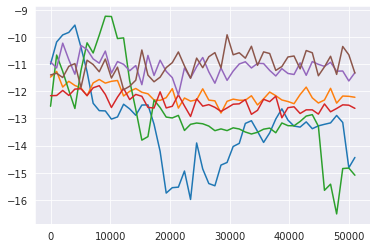

In [88]:
reward_plot_all(rewards)